# Import data

In [118]:
# !pip install seaborn --user
# !pip install tensorflow
# !pip install image-classifiers

In [119]:
import os
import tensorflow as tf
from keras import callbacks, Model
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import optimizers
from keras.utils.io_utils import HDF5Matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import random
import seaborn as sns
from sklearn import datasets, metrics

%matplotlib inline

In [120]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3067090328623752102
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2434087059921439119
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13557708049943926534
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7511012148
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7097515021206803978
physical_device_desc: "device: 0, name: Tesla M60, pci bus id: 0000:00:1e.0, compute capability: 5.2"
]


# Classificando imagens em Landmarks

## Lendo o conjunto de dados

In [121]:
seed = random.seed(42)

sample_datagen = ImageDataGenerator(rescale=1./255)
base_path = '/home/ubuntu/landmarks/landmarks'
target_size = (224, 224)
input_shape = (224, 224, 3)
classes = ["47378", "120885", "85758", "180901", "48522", "101399", 
           "190822", "97734", "146250", "186080", "21253", "142644", 
           "31531", "165596", "56827", "38482", "20102", "178519", 
           "152827", "173511"]


sample_generator = sample_datagen.flow_from_directory(base_path + '/subset_train',
                                                      target_size=target_size,
                                                      batch_size=32,
                                                      class_mode="sparse",
                                                      seed = seed)

sample_test_generator = sample_datagen.flow_from_directory(base_path + "/subset_test",
                                                           target_size = target_size,
                                                           batch_size = 32,
                                                           class_mode = "categorical",
                                                           seed = seed)

total_classes = np.max(sample_generator.labels) + 1

x_sample, y_sample = sample_generator.next()
x_sample_test, y_sample_test = sample_test_generator.next()
print('\n')
print('Showing y sample:', y_sample)
print('\n')
print('samples in train: %i' % sample_generator.labels.shape,
      'samples in test: %i' % sample_test_generator.labels.shape,
      'features: %s' % str(x_sample.shape[1:]),
      'classes: %i' % total_classes,
      sep='\n', end='\n\n')

print('shape:', x_sample.shape, x_sample_test.shape)
print(total_classes)

Found 12508 images belonging to 20 classes.
Found 3128 images belonging to 20 classes.


Showing y sample: [ 3. 12. 16.  1. 19.  2.  4.  9.  4.  7. 17. 13. 14.  3. 13.  5.  5.  0.
  0.  9.  9. 16. 13.  5.  9.  1.  0.  5.  0. 18.  7. 17.]


samples in train: 12508
samples in test: 3128
features: (224, 224, 3)
classes: 20

shape: (32, 224, 224, 3) (32, 224, 224, 3)
20


## Lendo as 32 primeiras amostras no conjunto de treinamento

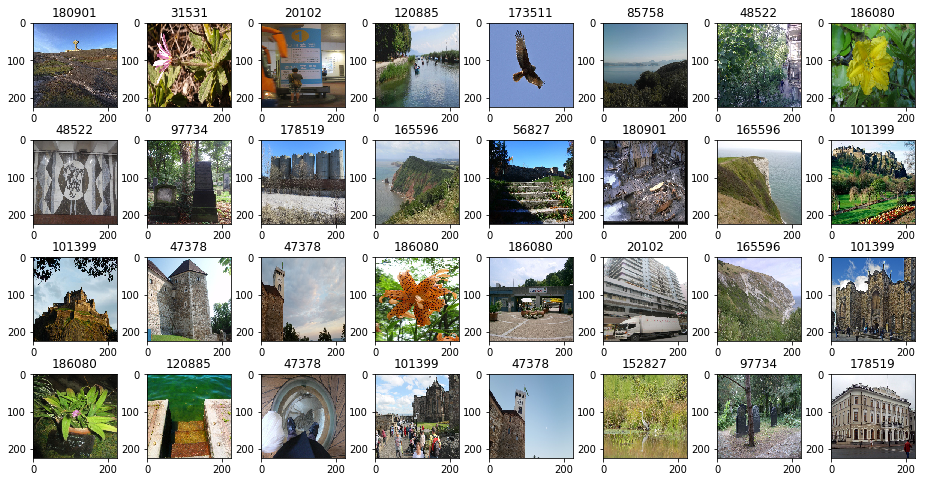

In [122]:
plt.figure(figsize=(16, 8))
for i in range(4 * 8):
    plt.subplot(4, 8, i+1)
    plt.subplots_adjust(hspace=0.4)
    plt.imshow(x_sample[i])
    plt.title("{}".format(classes[int(y_sample[i])]))

## Visualizando frequência das classes no conjunto

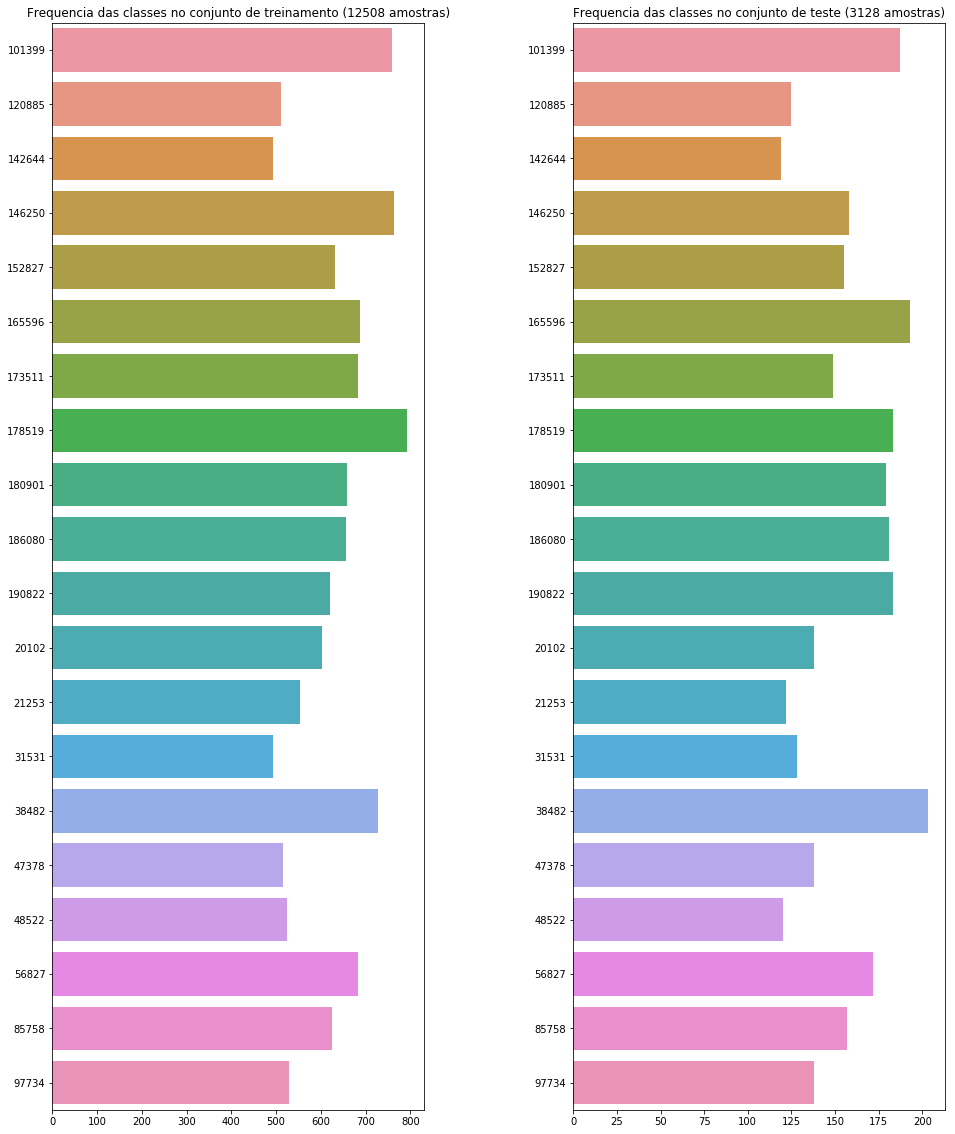

In [123]:
plt.figure(figsize=(16, 20))
plt.subplots_adjust(wspace=0.4)
plt.subplot(121)
plt.title('Frequencia das classes no conjunto de treinamento (%i amostras)' % len(sample_generator.labels))
_, counts = np.unique(sample_generator.labels, return_counts=True)
sns.barplot(counts, classes, orient='h')

plt.subplot(122)
plt.title('Frequencia das classes no conjunto de teste (%i amostras)' % len(sample_test_generator.labels))
_, counts = np.unique(sample_test_generator.labels, return_counts=True)
sns.barplot(counts, classes, orient='h')

# Preprocessamento das imagens de treino e validação

##Utilizaremos 20% da base de treinamento para validação

In [124]:
train_batch_size = 32 
val_batch_size = 32 
test_batch_size = 32

train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
train_generator = train_datagen.flow_from_directory(base_path + "/subset_train",
                                                    target_size = target_size,
                                                    batch_size = train_batch_size,
                                                    class_mode = "categorical",
                                                    subset = 'training')

validation_generator = train_datagen.flow_from_directory(base_path + "/subset_train",
                                                         target_size = target_size,
                                                         batch_size = val_batch_size,
                                                         class_mode = "categorical",
                                                         subset ='validation')

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(base_path + "/subset_test",
                                                  target_size = target_size,
                                                  batch_size = test_batch_size,
                                                  class_mode = "categorical")

Found 10016 images belonging to 20 classes.
Found 2492 images belonging to 20 classes.
Found 3128 images belonging to 20 classes.


# Parâmetros para treinamento e validação

In [125]:
rms = optimizers.RMSprop(lr = 0.0002,
                         decay = 1e-6)

device = '/gpu:0'

epochs = 8

train_steps = train_generator.samples // train_batch_size

validation_steps = validation_generator.samples // val_batch_size

test_steps = test_generator.samples // test_batch_size

# Funções de auxílio

In [ ]:
df_resultado = pd.DataFrame(columns=["Rede", 
                                     "train_acc", 
                                     "train_loss", 
                                     "val_acc", 
                                     "val_loss"])
def salvar_resultado(rede,
                     train_acc,
                     train_loss,
                     val_acc,
                     val_loss,
                     df):
  
    return df.append({
            "Rede" : rede,
            "train_acc": train_acc,
            "train_loss" : train_loss,
            "val_acc": val_acc,
            "val_loss": val_loss
        },
        ignore_index = True)

In [127]:
def train_model(model, 
                name, 
                train_g = train_generator, 
                validation_g = validation_generator, 
                factor = 1,
                train_epochs = epochs):
  train_g.reset()
  validation_g.reset()
  new_epoch = train_epochs * factor
  patience = new_epoch // 3
  with tf.device(device):
      return model.fit_generator(generator = train_g,
                                 steps_per_epoch = train_steps / factor,
                                 epochs = new_epoch,
                                 verbose = 1,
                                 validation_data = validation_g,
                                 validation_steps = validation_steps,
                                 callbacks=[callbacks.TerminateOnNaN(),
                                            callbacks.ReduceLROnPlateau(patience = patience),
                                            callbacks.ModelCheckpoint('./' + name + '.weights.h5',
                                                                      save_best_only=True,
                                                                      verbose=1),
                                            callbacks.EarlyStopping(patience = patience,
                                                                    restore_best_weights = True,
                                                                    verbose = 1)])

In [128]:
def learning_curve_model(history):

  plt.figure(figsize=(16, 6))
  
  plt.subplot(121)  
  plt.plot(history.history['acc'])  
  plt.plot(history.history['val_acc'])  
  plt.title('model accuracy')  
  plt.ylabel('accuracy')  
  plt.xlabel('epoch')  
  plt.legend(['train', 'val'], loc='upper left')  
   
  # summarize history for loss  
   
  plt.subplot(122)  
  plt.plot(history.history['loss'])  
  plt.plot(history.history['val_loss'])  
  plt.title('model loss')  
  plt.ylabel('loss')  
  plt.xlabel('epoch')  
  plt.legend(['train', 'val'], loc='upper left')  
  plt.show()

In [129]:
def evaluate_generator_model(model, name, generator=validation_generator, steps=validation_steps):
  generator.reset()
  score_val = model.evaluate_generator(generator = generator, steps = steps)
  print('[' + name +'] loss:', score_val[0])
  print('[' + name +'] accuracy (NOT BALANCED):', score_val[1])
  return score_val

In [130]:
def predict_generator_model(model, generator = validation_generator, steps = validation_steps):
  generator.reset()

  y_val_final = []
  prediction_final = []
  for i in range(1, generator.samples // steps + 1):
    x_val, y_val = generator.next()
    probabilities = model.predict(x_val)

    prediction_final =  np.append(prediction_final, np.argmax(probabilities, axis=1))  
    y_val_final = np.append(y_val_final, np.argmax(y_val, axis=1))
    
  return y_val_final, prediction_final

In [131]:
def classification_report_model(y_val_final, prediction_final, labels=classes):
  print(metrics.classification_report(y_val_final, prediction_final, target_names=labels, output_dict= False))

  return metrics.classification_report(y_val_final, prediction_final, target_names=labels, output_dict= True)

In [132]:
def confusion_matrix_model(y_test, predictions, labels=classes):
  c = metrics.confusion_matrix(y_test, predictions)
  r = c / c.sum(axis=1).reshape(-1, 1)

  plt.figure(figsize=(18, 14))
  ax = sns.heatmap(r, linewidths=.5, cmap='YlGnBu', xticklabels=labels, yticklabels=labels);
  plt.show()
  
  showing = 10

  ordered_by_scores = np.argsort(np.diag(r))
  labels_sorted_by_score = np.asarray(labels)[ordered_by_scores]

  print('\nClasses incorretamente classificadas pelo modelo, com maior frequência:\n ',
        *('%s: %s\n' % pair for pair in zip(labels_sorted_by_score[:showing],
                                          np.diag(r)[ordered_by_scores])))

  print('\nClasses incorretamente classificadas pelo modelo, com menor frequência:\n ',
        *('%s: %s\n' % pair for pair in zip(labels_sorted_by_score[::-1][:showing],
                                          np.diag(r)[ordered_by_scores[::-1]])))
  return r

In [174]:
def evaluate_model(model, name, generator = validation_generator, steps = validation_steps):
  print('*** Prediction model - Part (1/5)****')
  (y_val, prediction) = predict_generator_model(model, generator, steps)
  print('*** Classification model - Part (2/5)****')
  metric = classification_report_model(y_val, prediction)
  print('*** Confusion matrix model - Part (3/5)****')
  r = confusion_matrix_model(y_val, prediction)
  
  print('*** Evaluate model - Part (4/5)****')
  val_score = evaluate_generator_model(model, name + '_val', generator, steps)
  train_score = evaluate_generator_model(model, name + '_train', train_generator, train_steps)
  
  print('*** Saving results - Part (5/5)****')
  df_resultado = salvar_resultado(name, train_score[1], train_score[0], val_score[1], val_score[0], df_resultado)

In [134]:
def evaluate_test_model(model, name, generator = test_generator, steps = test_batch_size):
  print('*** Prediction model - Part (1/4)****')
  (y_val, prediction) = predict_generator_model(model, generator, steps)
  print('*** Classification model - Part (2/4)****')
  metric = classification_report_model(y_val, prediction)
  print('*** Confusion matrix model - Part (3/4)****')
  r = confusion_matrix_model(y_val, prediction)
  
  print('*** Evaluate model - Part (4/4)****')
  evaluate_generator_model(model, name + '_test', generator, steps)

# Rede *Homemade*

## Definindo a rede

In [135]:
def build_homemade():
  model = Sequential()

  model.add(Conv2D(filters = 10,
                      kernel_size = [3, 3],
                      name = "conv_1",
                      activation = "relu",
                      input_shape = input_shape))
  model.add(MaxPool2D(pool_size = [2, 2], name = "pool_1"))

  model.add(Conv2D(filters = 20,
                       kernel_size = [3, 3],
                       name = "conv_2",
                       activation = "relu"))
  model.add(Dropout(rate = 0.5, name = "do_1"))
  model.add(MaxPool2D(pool_size = [2, 2], name = "pool_2"))

  model.add(Flatten())
  model.add(Dense(units = total_classes,name = "dense_1", activation = 'softmax'))

  model.compile(optimizer = rms,
                    loss = 'categorical_crossentropy',
                    metrics=['accuracy'])

  model.summary()
  return model;

homemade_model = build_homemade()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 111, 111, 10)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 109, 109, 20)      1820      
_________________________________________________________________
do_1 (Dropout)               (None, 109, 109, 20)      0         
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 54, 54, 20)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 58320)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1166420   
Total para

## Treinando o modelo

In [136]:
history_homemade = train_model(homemade_model, name =  'homemade-subset')

Epoch 1/8
313/313 [==============================] - 113s 362ms/step - loss: 2.7566 - acc: 0.2233 - val_loss: 2.4164 - val_acc: 0.3068

Epoch 00001: val_loss improved from inf to 2.41639, saving model to ./homemade-subset.weights.h5
Epoch 2/8
313/313 [==============================] - 98s 312ms/step - loss: 2.0832 - acc: 0.4000 - val_loss: 2.2582 - val_acc: 0.3687

Epoch 00002: val_loss improved from 2.41639 to 2.25816, saving model to ./homemade-subset.weights.h5
Epoch 3/8
313/313 [==============================] - 99s 315ms/step - loss: 1.8191 - acc: 0.4852 - val_loss: 2.1680 - val_acc: 0.3886

Epoch 00003: val_loss improved from 2.25816 to 2.16804, saving model to ./homemade-subset.weights.h5
Epoch 4/8
313/313 [==============================] - 97s 309ms/step - loss: 1.6002 - acc: 0.5534 - val_loss: 2.1197 - val_acc: 0.3837

Epoch 00004: val_loss improved from 2.16804 to 2.11965, saving model to ./homemade-subset.weights.h5
Epoch 5/8
313/313 [==============================] - 98s 31

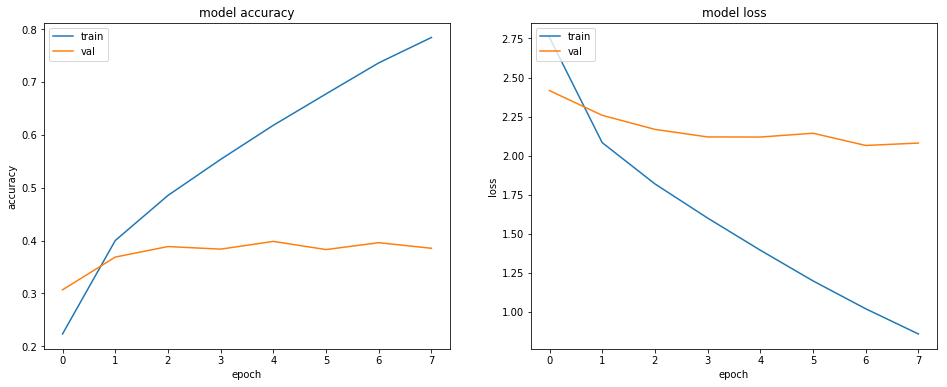

In [137]:
learning_curve_model(history_homemade)

## Avaliando modelo treinado

*** Prediction model - Part (1/5)****
*** Classification model - Part (2/5)****
              precision    recall  f1-score   support

       47378       0.67      0.20      0.30        41
      120885       0.56      0.26      0.36        34
       85758       0.58      0.50      0.54        62
      180901       0.69      0.39      0.49        57
       48522       0.23      0.10      0.14        49
      101399       0.34      0.21      0.26        61
      190822       0.33      0.02      0.04        42
       97734       0.66      0.67      0.67        43
      146250       0.52      0.44      0.48        66
      186080       0.55      0.78      0.65        54
       21253       0.65      0.47      0.55        51
      142644       0.61      0.45      0.52        31
       31531       0.36      0.21      0.27        38
      165596       0.64      0.32      0.42        57
       56827       0.38      0.35      0.37        51
       38482       0.49      0.27      0.34        64
 

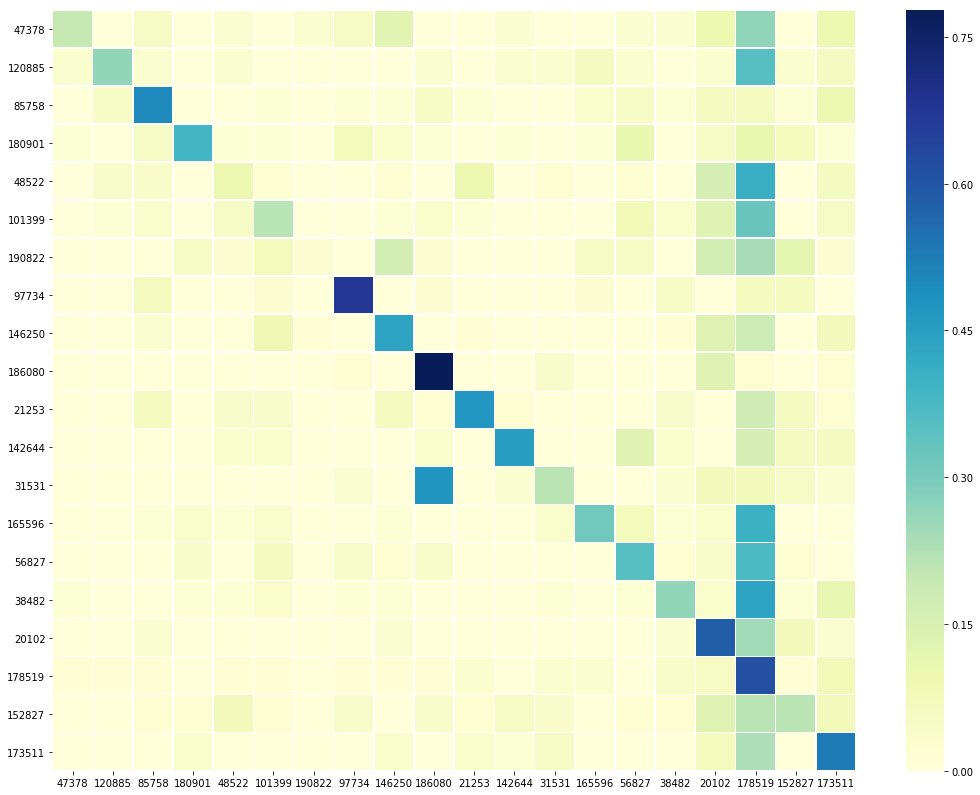


Classes incorretamente classificadas pelo modelo, com maior frequência:
  190822: 0.023809523809523808
 48522: 0.10204081632653061
 47378: 0.1951219512195122
 31531: 0.21052631578947367
 152827: 0.21153846153846154
 101399: 0.21311475409836064
 120885: 0.2647058823529412
 38482: 0.265625
 165596: 0.3157894736842105
 56827: 0.35294117647058826


Classes incorretamente classificadas pelo modelo, com menor frequência:
  186080: 0.7777777777777778
 97734: 0.6744186046511628
 178519: 0.6164383561643836
 20102: 0.5853658536585366
 173511: 0.5263157894736842
 85758: 0.5
 21253: 0.47058823529411764
 142644: 0.45161290322580644
 146250: 0.4393939393939394
 180901: 0.38596491228070173

*** Evaluate model - Part (4/5)****
[Homemade_val] loss: 2.0990084796756894
[Homemade_val] accuracy (NOT BALANCED): 0.37337662337662336
[Homemade_train] loss: 1.0084461569786072
[Homemade_train] accuracy (NOT BALANCED): 0.8325678913738019
*** Saving results - Part (5/5)****


In [163]:
evaluate_model(homemade_model, 'Homemade')

# ResNet18 - Transfer Learning

## Feature Extraction

### Definindo a rede

In [139]:
from classification_models.resnet import ResNet18, preprocess_input

def build_resNet18():
  model = ResNet18(input_shape = input_shape,
                   weights = "imagenet",
                   include_top=False)

  for layer in model.layers:
      layer.trainable = False

  output = model.output

  output = Flatten(name = 'flat_mdc')(output)

  output = Dense(total_classes,
                 activation ='softmax',
                 name = 'saida_mdc')(output)

  model = Model(inputs = model.input, outputs = output)

  model.compile(loss ='categorical_crossentropy', 
                optimizer = rms, 
                metrics=['accuracy'])
  
  model.summary()
  return model

resNet18_feature_model = build_resNet18()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_163 (ZeroPadding (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_163[0][0]         
__________________________________________________________________________________________________
bn0 (Batch

## Fine Tuning

### Definindo a rede

In [140]:
def build_resNet18_tuning():
  model = build_resNet18()
  for layer in model.layers:
      layer.trainable = True

  model.compile(loss ='categorical_crossentropy',
                optimizer = rms,
                metrics=['accuracy'])

  model.summary()
  return model

resNet18_tunning_model = build_resNet18_tuning()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_181 (ZeroPadding (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_181[0][0]         
__________________________________________________________________________________________________
bn0 (Batch

### Treinando o modelo

In [141]:
history_resNet18_tuning = train_model(resNet18_tunning_model, name =  'ResNet18 - Tuning')

Epoch 1/8
313/313 [==============================] - 120s 384ms/step - loss: 2.2132 - acc: 0.5640 - val_loss: 4.8479 - val_acc: 0.5061

Epoch 00001: val_loss improved from inf to 4.84792, saving model to ./ResNet18 - Tuning.weights.h5
Epoch 2/8
313/313 [==============================] - 100s 319ms/step - loss: 0.8064 - acc: 0.7973 - val_loss: 2.1851 - val_acc: 0.6793

Epoch 00002: val_loss improved from 4.84792 to 2.18513, saving model to ./ResNet18 - Tuning.weights.h5
Epoch 3/8
313/313 [==============================] - 100s 320ms/step - loss: 0.4554 - acc: 0.8794 - val_loss: 2.3178 - val_acc: 0.6959

Epoch 00003: val_loss did not improve from 2.18513
Epoch 4/8
313/313 [==============================] - 99s 318ms/step - loss: 0.3178 - acc: 0.9163 - val_loss: 2.1709 - val_acc: 0.7138

Epoch 00004: val_loss improved from 2.18513 to 2.17093, saving model to ./ResNet18 - Tuning.weights.h5
Epoch 5/8
313/313 [==============================] - 101s 322ms/step - loss: 0.2750 - acc: 0.9357 - v

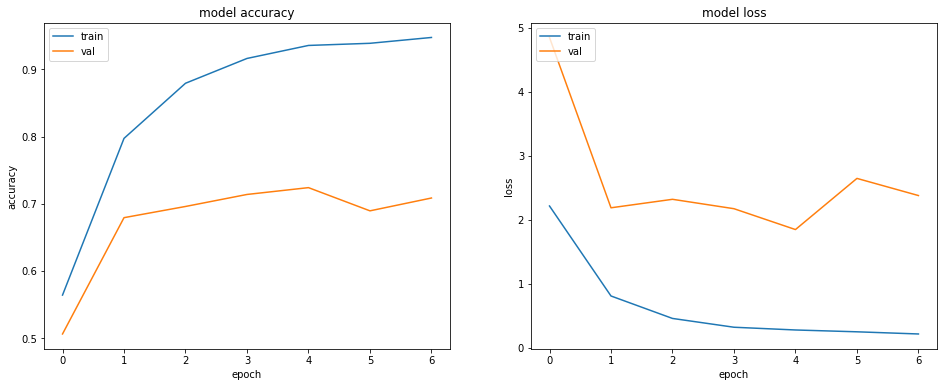

In [142]:
learning_curve_model(history_resNet18_tuning)

### Avaliando modelo treinado

*** Prediction model - Part (1/5)****
*** Classification model - Part (2/5)****
              precision    recall  f1-score   support

       47378       0.55      0.87      0.67        39
      120885       0.73      0.73      0.73        44
       85758       0.89      0.74      0.80        53
      180901       0.83      0.69      0.75        51
       48522       0.58      0.36      0.44        39
      101399       0.44      0.87      0.59        68
      190822       0.88      0.69      0.78        55
       97734       0.85      0.80      0.82        35
      146250       0.84      0.70      0.77        70
      186080       0.89      0.73      0.80        45
       21253       0.91      0.96      0.93        45
      142644       0.90      0.74      0.81        38
       31531       0.64      0.85      0.73        40
      165596       0.84      0.82      0.83        50
       56827       0.85      0.81      0.83        58
       38482       0.65      0.82      0.73        62
 

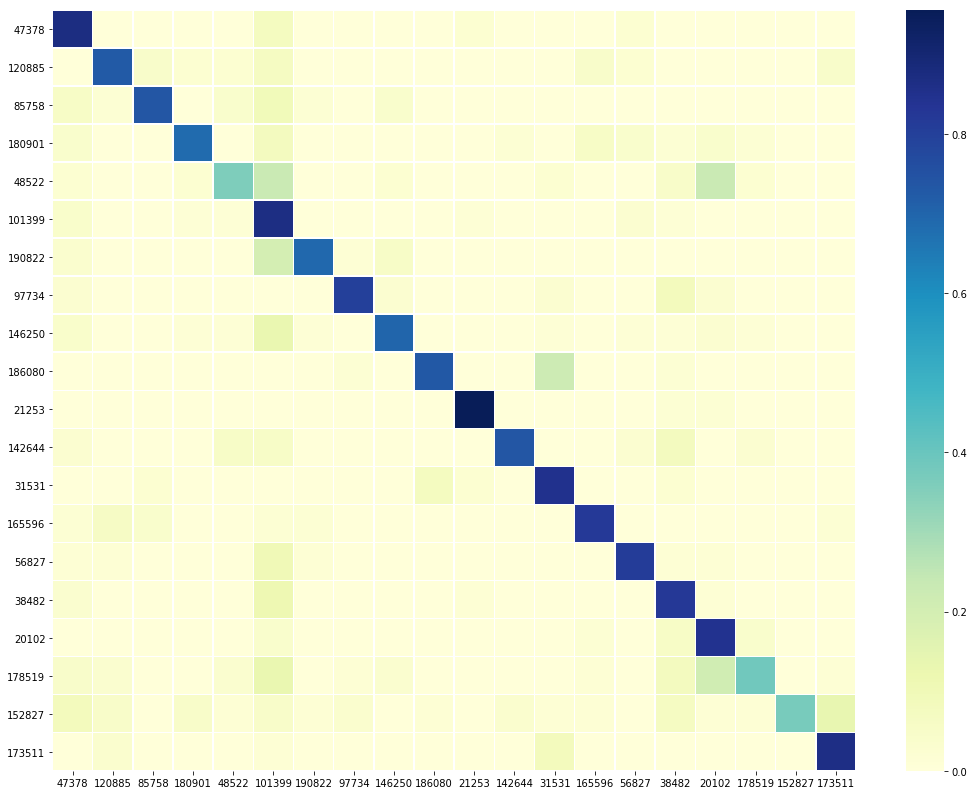


Classes incorretamente classificadas pelo modelo, com maior frequência:
  48522: 0.358974358974359
 152827: 0.3728813559322034
 178519: 0.3870967741935484
 180901: 0.6862745098039216
 190822: 0.6909090909090909
 146250: 0.7
 120885: 0.7272727272727273
 186080: 0.7333333333333333
 85758: 0.7358490566037735
 142644: 0.7368421052631579


Classes incorretamente classificadas pelo modelo, com menor frequência:
  21253: 0.9555555555555556
 47378: 0.8717948717948718
 101399: 0.8676470588235294
 173511: 0.864406779661017
 31531: 0.85
 20102: 0.8461538461538461
 38482: 0.8225806451612904
 165596: 0.82
 56827: 0.8103448275862069
 97734: 0.8

*** Evaluate model - Part (4/5)****
[ResNet18 - Tuning_val] loss: 1.8581397839180835
[ResNet18 - Tuning_val] accuracy (NOT BALANCED): 0.7228084415584416
[ResNet18 - Tuning_train] loss: 0.286199589927172
[ResNet18 - Tuning_train] accuracy (NOT BALANCED): 0.9326078274760383
*** Saving results - Part (5/5)****


In [164]:
evaluate_model(resNet18_tunning_model, 'ResNet18 - Tuning')

# VGG16 - Transfer Learning

## Feature Extraction

### Definindo a rede

In [144]:
from keras.layers import Input
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

def build_vgg16_feature():
  model = VGG16(input_shape = input_shape,
                      weights = "imagenet",
                      include_top = False)

  for layer in model.layers:
      layer.trainable = False

  output = model.output

  output = Flatten(name = 'flat_mdc')(output)

  output = Dense(total_classes,
                 activation ='softmax',
                 name = 'saida_mdc')(output)

  model = Model(inputs = model.input,
                      outputs = output)

  model.compile(loss ='categorical_crossentropy',
                      optimizer = rms,
                      metrics=['accuracy'])

  model.summary()
  return model

vgg16_feature_model = build_vgg16_feature()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Fine Tuning

### Definindo a rede

In [145]:
def build_vgg16_tuning():
  model = build_vgg16_feature()

  for layer in model.layers:
      layer.trainable = True

  model.compile(loss ='categorical_crossentropy',
                optimizer = rms,
                metrics=['accuracy'])

  model.summary()
  return model
  
vgg16_tunning_model = build_vgg16_tuning();

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Treinando o modelo

In [146]:
history_vgg16_tuning = train_model(vgg16_tunning_model, name =  'VGG16 - Tunning')

Epoch 1/8
313/313 [==============================] - 239s 765ms/step - loss: 1.9433 - acc: 0.4106 - val_loss: 1.4804 - val_acc: 0.5528

Epoch 00001: val_loss improved from inf to 1.48044, saving model to ./VGG16 - Tunning.weights.h5
Epoch 2/8
313/313 [==============================] - 222s 711ms/step - loss: 1.1320 - acc: 0.6600 - val_loss: 1.2149 - val_acc: 0.6447

Epoch 00002: val_loss improved from 1.48044 to 1.21489, saving model to ./VGG16 - Tunning.weights.h5
Epoch 3/8
313/313 [==============================] - 222s 710ms/step - loss: 0.7336 - acc: 0.7812 - val_loss: 1.2275 - val_acc: 0.6484

Epoch 00003: val_loss did not improve from 1.21489
Epoch 4/8
313/313 [==============================] - 222s 710ms/step - loss: 0.4662 - acc: 0.8569 - val_loss: 1.1360 - val_acc: 0.6809

Epoch 00004: val_loss improved from 1.21489 to 1.13597, saving model to ./VGG16 - Tunning.weights.h5
Epoch 5/8
313/313 [==============================] - 222s 709ms/step - loss: 0.2697 - acc: 0.9167 - val_lo

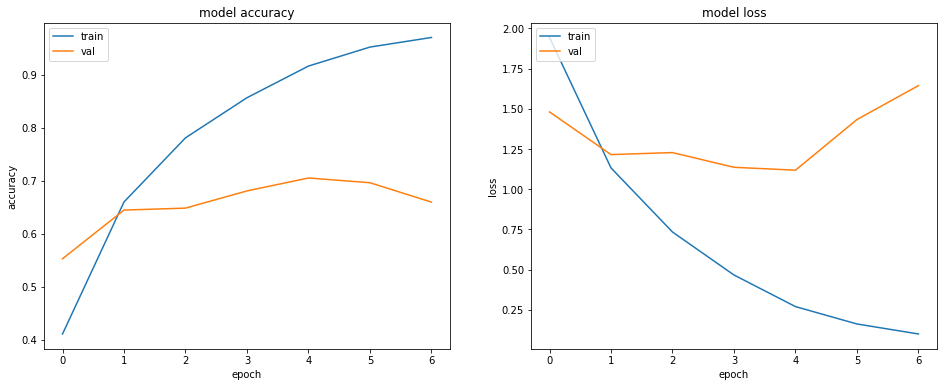

In [147]:
learning_curve_model(history_vgg16_tuning)

### Avaliando modelo treinado

*** Prediction model - Part (1/5)****
*** Classification model - Part (2/5)****
              precision    recall  f1-score   support

       47378       0.79      0.77      0.78        39
      120885       0.64      0.86      0.73        43
       85758       0.78      0.59      0.67        49
      180901       0.92      0.59      0.72        59
       48522       0.37      0.33      0.35        42
      101399       0.61      0.67      0.64        58
      190822       0.96      0.86      0.91        50
       97734       0.83      0.79      0.81        38
      146250       0.80      0.54      0.64        67
      186080       0.65      0.91      0.76        55
       21253       0.82      0.86      0.84        43
      142644       0.73      0.63      0.68        43
       31531       0.63      0.54      0.58        35
      165596       0.54      0.85      0.66        59
       56827       0.68      0.83      0.75        52
       38482       0.81      0.76      0.79        63
 

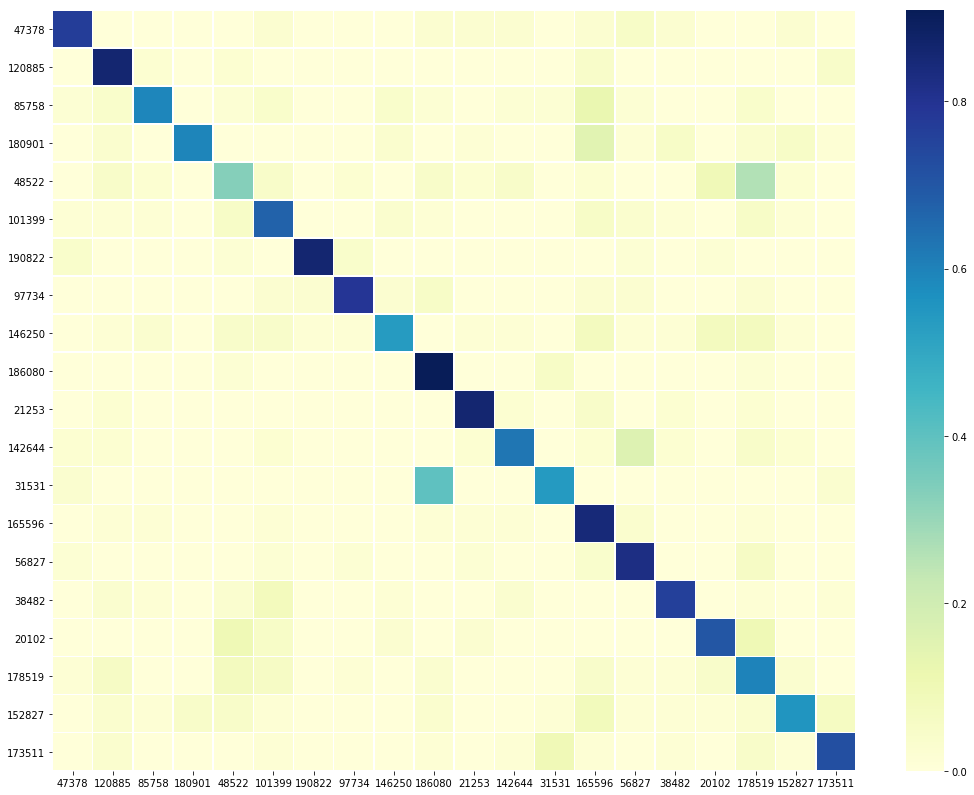


Classes incorretamente classificadas pelo modelo, com maior frequência:
  48522: 0.3333333333333333
 146250: 0.5373134328358209
 31531: 0.5428571428571428
 152827: 0.5573770491803278
 85758: 0.5918367346938775
 180901: 0.5932203389830508
 178519: 0.5970149253731343
 142644: 0.627906976744186
 101399: 0.6724137931034483
 20102: 0.7


Classes incorretamente classificadas pelo modelo, com menor frequência:
  186080: 0.9090909090909091
 21253: 0.8604651162790697
 120885: 0.8604651162790697
 190822: 0.86
 165596: 0.847457627118644
 56827: 0.8269230769230769
 97734: 0.7894736842105263
 47378: 0.7692307692307693
 38482: 0.7619047619047619
 173511: 0.7213114754098361

*** Evaluate model - Part (4/5)****
[VGG16 - Tunning_val] loss: 1.131724995065045
[VGG16 - Tunning_val] accuracy (NOT BALANCED): 0.7037337662337663
[VGG16 - Tunning_train] loss: 0.11953991255202233
[VGG16 - Tunning_train] accuracy (NOT BALANCED): 0.9747404153354633
*** Saving results - Part (5/5)****


In [165]:
evaluate_model(vgg16_tunning_model, 'VGG16 - Tunning')

# InceptionV3 - Transfer Learning

## Feature Extraction

### Definindo a rede

In [149]:
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input


def build_inceptionV3_feature_model():
  model = InceptionV3(input_shape = input_shape,
                                  weights = "imagenet",
                                  include_top = False)

  for layer in model.layers:
      layer.trainable = False

  output = model.output

  output = Flatten(name = 'flat_mdc')(output)

  output = Dense(total_classes,
                 activation ='softmax',
                 name = 'saida_mdc')(output)

  model = Model(inputs = model.input,
                            outputs = output)

  model.compile(loss ='categorical_crossentropy',
                            optimizer = rms,
                            metrics=['accuracy'])

  model.summary()
  return model

inceptionv3_feature_model = build_inceptionV3_feature_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_377 (Conv2D)             (None, 111, 111, 32) 864         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_377 (BatchN (None, 111, 111, 32) 96          conv2d_377[0][0]                 
__________________________________________________________________________________________________
activation_377 (Activation)     (None, 111, 111, 32) 0           batch_normalization_377[0][0]    
__________________________________________________________________________________________________
conv2d_378

## Fine Tuning

### Definindo a rede

In [150]:
def build_inceptionV3_tunning_model():
  model = build_inceptionV3_feature_model()
  for layer in model.layers:
      layer.trainable = True

  model.compile(loss ='categorical_crossentropy',
                            optimizer = rms,
                            metrics=['accuracy'])

  model.summary()
  return model

inceptionv3_tunning_model = build_inceptionV3_tunning_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_471 (Conv2D)             (None, 111, 111, 32) 864         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_471 (BatchN (None, 111, 111, 32) 96          conv2d_471[0][0]                 
__________________________________________________________________________________________________
activation_471 (Activation)     (None, 111, 111, 32) 0           batch_normalization_471[0][0]    
__________________________________________________________________________________________________
conv2d_472

### Treinando o modelo

In [151]:
history_inceptionv3_tuning = train_model(inceptionv3_tunning_model, name =  'InceptionV3 - Tunning')

Epoch 1/8
313/313 [==============================] - 188s 599ms/step - loss: 2.9491 - acc: 0.1295 - val_loss: 2.6838 - val_acc: 0.2240

Epoch 00001: val_loss improved from inf to 2.68382, saving model to ./InceptionV3 - Tunning.weights.h5
Epoch 2/8
313/313 [==============================] - 154s 493ms/step - loss: 2.3524 - acc: 0.3093 - val_loss: 2.2598 - val_acc: 0.3382

Epoch 00002: val_loss improved from 2.68382 to 2.25981, saving model to ./InceptionV3 - Tunning.weights.h5
Epoch 3/8
313/313 [==============================] - 154s 492ms/step - loss: 1.9441 - acc: 0.4433 - val_loss: 1.9673 - val_acc: 0.4118

Epoch 00003: val_loss improved from 2.25981 to 1.96729, saving model to ./InceptionV3 - Tunning.weights.h5
Epoch 4/8
313/313 [==============================] - 154s 493ms/step - loss: 1.6614 - acc: 0.5276 - val_loss: 1.7754 - val_acc: 0.4654

Epoch 00004: val_loss improved from 1.96729 to 1.77545, saving model to ./InceptionV3 - Tunning.weights.h5
Epoch 5/8
313/313 [=============

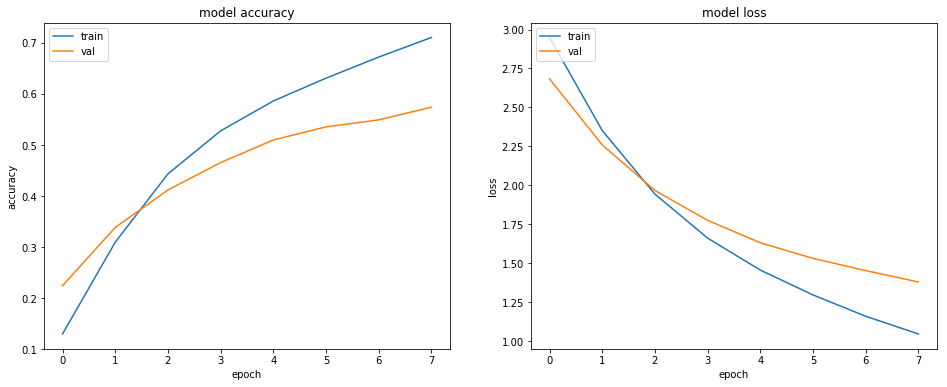

In [152]:
learning_curve_model(history_inceptionv3_tuning)

### Avaliando modelo treinado

*** Prediction model - Part (1/5)****
*** Classification model - Part (2/5)****
              precision    recall  f1-score   support

       47378       0.68      0.46      0.55        41
      120885       0.46      0.46      0.46        41
       85758       0.43      0.44      0.44        52
      180901       0.47      0.42      0.45        59
       48522       0.39      0.20      0.26        45
      101399       0.50      0.40      0.44        58
      190822       0.75      0.70      0.72        54
       97734       0.76      0.66      0.70        47
      146250       0.54      0.57      0.55        60
      186080       0.66      0.80      0.72        49
       21253       0.90      0.80      0.84        44
      142644       0.47      0.51      0.49        41
       31531       0.69      0.65      0.67        37
      165596       0.52      0.65      0.57        51
       56827       0.51      0.70      0.59        54
       38482       0.71      0.76      0.73        63
 

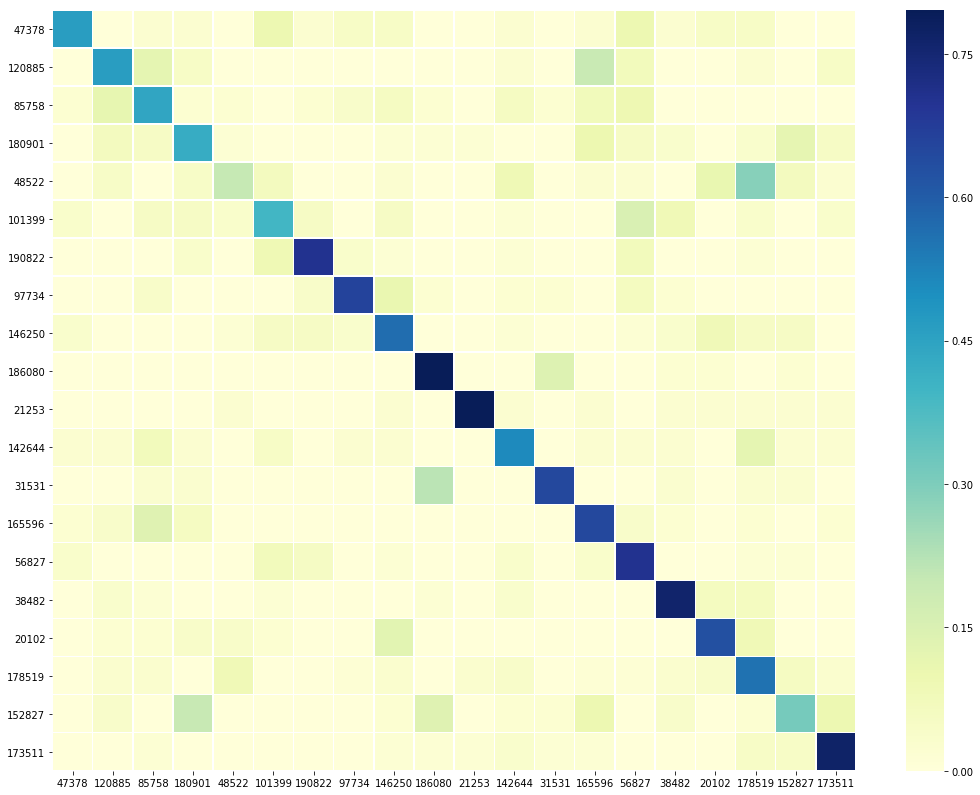


Classes incorretamente classificadas pelo modelo, com maior frequência:
  48522: 0.2
 152827: 0.3137254901960784
 101399: 0.39655172413793105
 180901: 0.423728813559322
 85758: 0.4423076923076923
 47378: 0.4634146341463415
 120885: 0.4634146341463415
 142644: 0.5121951219512195
 178519: 0.5571428571428572
 146250: 0.5666666666666667


Classes incorretamente classificadas pelo modelo, com menor frequência:
  186080: 0.7959183673469388
 21253: 0.7954545454545454
 173511: 0.7704918032786885
 38482: 0.7619047619047619
 56827: 0.7037037037037037
 190822: 0.7037037037037037
 97734: 0.6595744680851063
 31531: 0.6486486486486487
 165596: 0.6470588235294118
 20102: 0.6304347826086957

*** Evaluate model - Part (4/5)****
[InceptionV3 - Tunning_val] loss: 1.3842175835138792
[InceptionV3 - Tunning_val] accuracy (NOT BALANCED): 0.5698051948051948
[InceptionV3 - Tunning_train] loss: 0.791448952767034
[InceptionV3 - Tunning_train] accuracy (NOT BALANCED): 0.8007188498402555
*** Saving results - Part

In [166]:
evaluate_model(inceptionv3_tunning_model, 'InceptionV3 - Tunning')

# MobileNetV2 - Transfer Learning

## Feature Extraction

### Definindo a rede

In [154]:
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

def build_mobileNet_feature_model():
  model = MobileNetV2(input_shape = input_shape,
                                weights = "imagenet",
                                include_top = False)

  for layer in model.layers:
      layer.trainable = False

  output = model.output

  output = Flatten(name = 'flat_mdc')(output)

  output = Dense(total_classes,
                 activation ='softmax',
                 name = 'saida_mdc')(output)

  model = Model(inputs = model.input,
                          outputs = output)

  model.compile(loss ='categorical_crossentropy',
                          optimizer = rms,
                          metrics=['accuracy'])

  model.summary()
  return model

mobileNet_feature_model = build_mobileNet_feature_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

## Fine Tuning

### Definindo a rede

In [155]:
def build_mobileNet_tunning_model():
  model = build_mobileNet_feature_model()
  for layer in model.layers:
      layer.trainable = True

  model.compile(loss ='categorical_crossentropy',
                          optimizer = rms,
                          metrics=['accuracy'])

  model.summary()
  return model

mobileNet_tunning_model = build_mobileNet_tunning_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_14[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

### Treinando o modelo

In [156]:
history_mobileNet_tunning = train_model(mobileNet_tunning_model, name =  'MobileNet- Tunning')

Epoch 1/8
313/313 [==============================] - 190s 607ms/step - loss: 3.7037 - acc: 0.0939 - val_loss: 3.1228 - val_acc: 0.1680

Epoch 00001: val_loss improved from inf to 3.12279, saving model to ./MobileNet- Tunning.weights.h5
Epoch 2/8
313/313 [==============================] - 155s 495ms/step - loss: 2.7799 - acc: 0.2349 - val_loss: 2.5073 - val_acc: 0.2907

Epoch 00002: val_loss improved from 3.12279 to 2.50727, saving model to ./MobileNet- Tunning.weights.h5
Epoch 3/8
313/313 [==============================] - 155s 495ms/step - loss: 2.2366 - acc: 0.3628 - val_loss: 2.1408 - val_acc: 0.3846

Epoch 00003: val_loss improved from 2.50727 to 2.14082, saving model to ./MobileNet- Tunning.weights.h5
Epoch 4/8
313/313 [==============================] - 155s 496ms/step - loss: 1.8735 - acc: 0.4508 - val_loss: 1.8897 - val_acc: 0.4435

Epoch 00004: val_loss improved from 2.14082 to 1.88971, saving model to ./MobileNet- Tunning.weights.h5
Epoch 5/8
313/313 [=========================

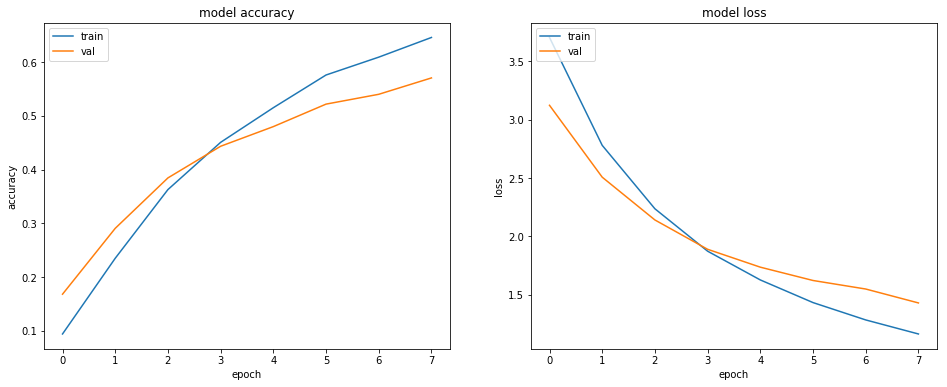

In [157]:
learning_curve_model(history_mobileNet_tunning)

### Avaliando modelo treinado

*** Prediction model - Part (1/5)****
*** Classification model - Part (2/5)****
              precision    recall  f1-score   support

       47378       0.78      0.64      0.70        39
      120885       0.40      0.51      0.45        39
       85758       0.54      0.45      0.49        56
      180901       0.49      0.52      0.50        64
       48522       0.28      0.24      0.26        42
      101399       0.50      0.50      0.50        56
      190822       0.70      0.78      0.74        51
       97734       0.61      0.75      0.67        44
      146250       0.45      0.45      0.45        62
      186080       0.65      0.76      0.70        59
       21253       0.83      0.81      0.82        43
      142644       0.49      0.52      0.51        42
       31531       0.55      0.55      0.55        42
      165596       0.67      0.50      0.57        56
       56827       0.62      0.62      0.62        53
       38482       0.68      0.80      0.74        54
 

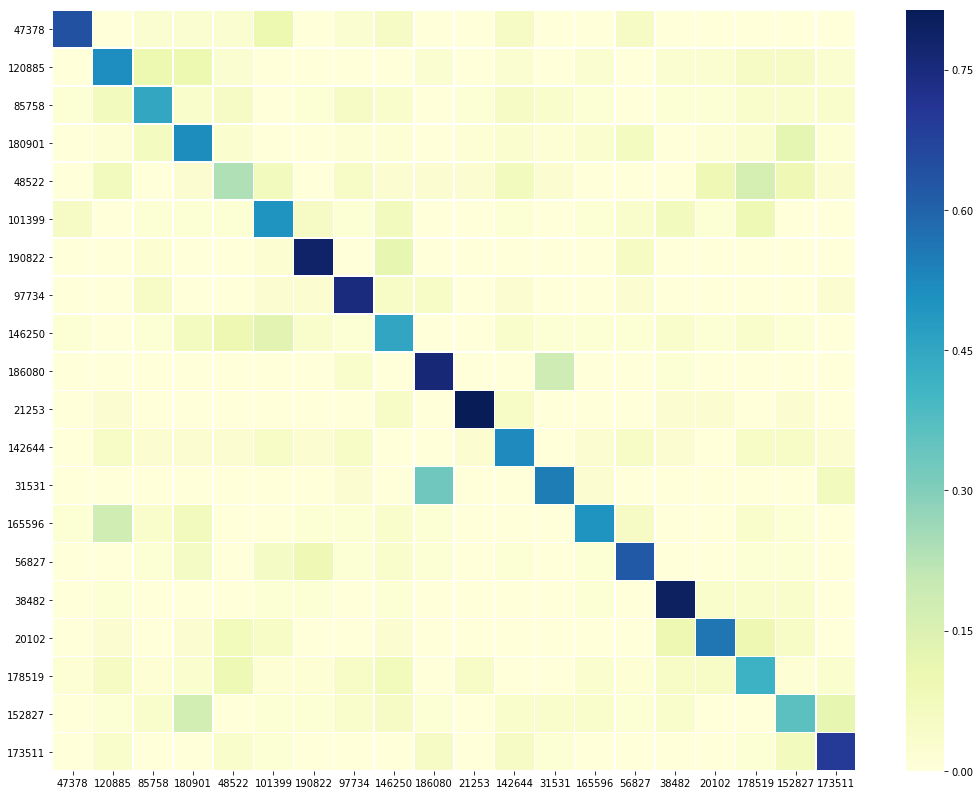


Classes incorretamente classificadas pelo modelo, com maior frequência:
  48522: 0.23809523809523808
 152827: 0.3620689655172414
 178519: 0.417910447761194
 85758: 0.44642857142857145
 146250: 0.45161290322580644
 101399: 0.5
 165596: 0.5
 120885: 0.5128205128205128
 180901: 0.515625
 142644: 0.5238095238095238


Classes incorretamente classificadas pelo modelo, com menor frequência:
  21253: 0.813953488372093
 38482: 0.7962962962962963
 190822: 0.7843137254901961
 186080: 0.7627118644067796
 97734: 0.75
 173511: 0.6964285714285714
 47378: 0.6410256410256411
 56827: 0.6226415094339622
 20102: 0.5609756097560976
 31531: 0.5476190476190477

*** Evaluate model - Part (4/5)****
[MobileNet - Tunning_val] loss: 1.4523278172914085
[MobileNet - Tunning_val] accuracy (NOT BALANCED): 0.5645292207792207
[MobileNet - Tunning_train] loss: 0.9282447918535421
[MobileNet - Tunning_train] accuracy (NOT BALANCED): 0.7194488817891374
*** Saving results - Part (5/5)****


UnboundLocalError: local variable 'df_resultado' referenced before assignment

In [175]:
evaluate_model(mobileNet_tunning_model, 'MobileNet - Tunning')

# Avaliando as redes

## Comparando resultados das redes propostas

In [ ]:
df_resultado.sort_values(by=["val_acc"])

## Avaliando no conjunto de teste(a melhor rede)

*** Prediction model - Part (1/4)****
*** Classification model - Part (2/4)****
              precision    recall  f1-score   support

       47378       0.64      0.83      0.72       138
      120885       0.71      0.70      0.70       124
       85758       0.76      0.75      0.76       156
      180901       0.86      0.68      0.76       177
       48522       0.64      0.42      0.51       120
      101399       0.48      0.89      0.62       182
      190822       0.85      0.72      0.78       182
       97734       0.92      0.78      0.84       135
      146250       0.80      0.66      0.72       157
      186080       0.88      0.77      0.82       180
       21253       0.85      0.85      0.85       122
      142644       0.85      0.69      0.76       119
       31531       0.75      0.88      0.81       127
      165596       0.83      0.77      0.79       192
       56827       0.72      0.72      0.72       171
       38482       0.68      0.86      0.76       200
 

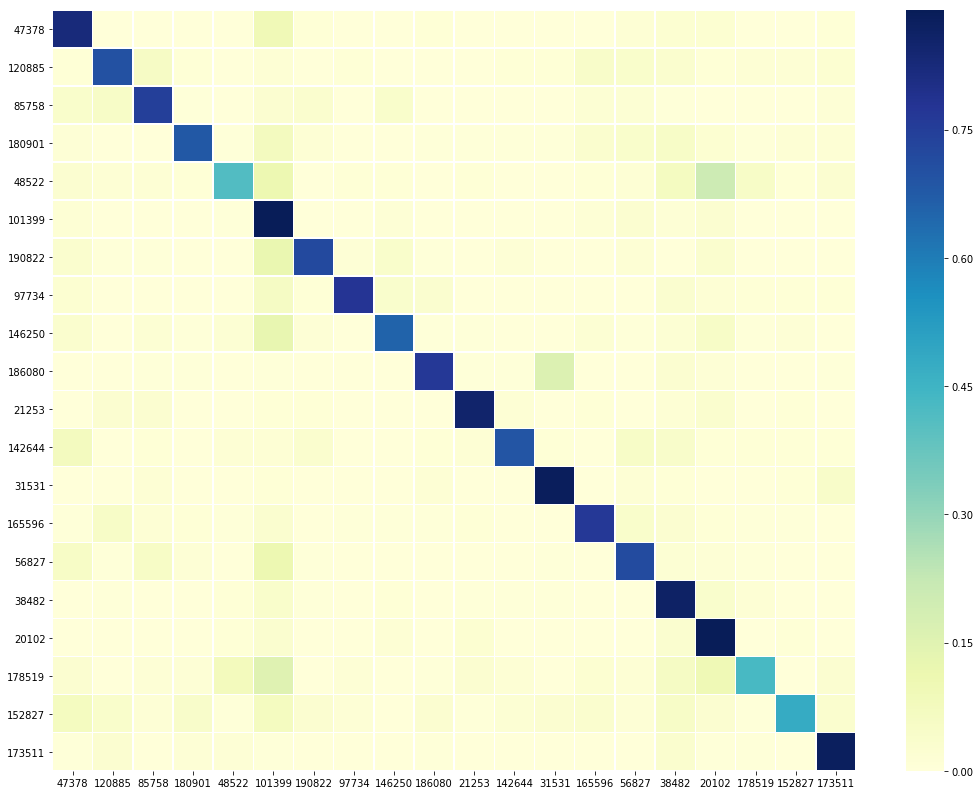


Classes incorretamente classificadas pelo modelo, com maior frequência:
  48522: 0.4166666666666667
 178519: 0.4340659340659341
 152827: 0.4774193548387097
 146250: 0.6560509554140127
 180901: 0.6836158192090396
 142644: 0.6890756302521008
 120885: 0.7016129032258065
 56827: 0.7192982456140351
 190822: 0.7197802197802198
 85758: 0.75


Classes incorretamente classificadas pelo modelo, com menor frequência:
  101399: 0.8901098901098901
 20102: 0.8897058823529411
 31531: 0.8818897637795275
 173511: 0.8791946308724832
 38482: 0.865
 21253: 0.8524590163934426
 47378: 0.8260869565217391
 97734: 0.7777777777777778
 186080: 0.7666666666666667
 165596: 0.765625

*** Evaluate model - Part (4/4)****
[ResNet18 - Tunning_test] loss: 1.9134210888296366
[ResNet18 - Tunning_test] accuracy (NOT BALANCED): 0.7158203125


In [161]:
evaluate_test_model(resNet18_tunning_model, 'ResNet18 - Tunning')